# Import libraries

In [1]:
!pip install googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40711 sha256=ff8c42a722c5db8e4055e2547e60111c5f634d0c8cc1ba132c6ff4c9431ad682
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps


In [2]:
!pip install hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039300 sha256=009d24c5c917e743b04d8ebf454a43c7baf5180718add6eccb05298bcf4fc637
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [3]:
!pip install folium

In [4]:
import pandas as pd
import numpy as np
import logging

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import folium
import matplotlib.cm as cm

from matplotlib import cm, colors as mcolors
from sklearn.cluster import DBSCAN
import hdbscan


import googlemaps
from datetime import datetime

from sklearn.metrics import silhouette_score, silhouette_samples

from math import radians, cos, sin, asin, sqrt

import joblib

import time
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# the directory where on_lift_events datasets are stored
data_path = '/content/'

In [7]:
# all CSV files in the directory ending with 'on_lift_events'
csv_files = [file for file in os.listdir(data_path) if file.endswith('on_lift_events.csv')]

In [8]:
csv_files

['df_100_on_lift_events.csv',
 'df_131_on_lift_events.csv',
 'df_310_on_lift_events.csv',
 'df_290_on_lift_events.csv',
 'df_166_on_lift_events.csv',
 'df_135_on_lift_events.csv',
 'df_206_on_lift_events.csv']

In [9]:
# an empty list to store your DataFrames
dataframes_list = []

# Loop through the CSV files and read each one into a DataFrame
for file in csv_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)


In [ ]:
#df.info for all datasets

for i, df in enumerate(dataframes_list):
    print(f"DataFrame {i+1} Info:")
    df.info()
    print("\n")

**Get Geocoded location names, start and end altitude, slope, duration of rides**

In [38]:
# Initialize Google Maps client with your API key
gmaps = googlemaps.Client(key='your API key')

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in meters between two points
    on the earth (specified in decimal degrees).
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers.
    return c * r * 1000  # Return distance in meters

def safe_reverse_geocode(lat, lng, client):
    try:
        response = client.reverse_geocode((lat, lng))
        return response[0]['formatted_address'] if response else 'Unknown Location'
    except Exception as e:
        print(f"Error during reverse geocoding: {e}")
        return 'Unknown Location'

def process_dataset(df, gmaps):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Calculate start and end times, and duration
    event_times = df.groupby('event')['Timestamp'].agg(['min', 'max']).reset_index()
    event_times['Duration'] = event_times['max'] - event_times['min']

    # Calculate start and end points for Latitude, Longitude, and Altitude
    start_points = df.groupby('event').agg({'Lat': 'first', 'Long': 'first', 'Alt(m)': 'first'}).reset_index().rename(columns={'Lat': 'Lat_start', 'Long': 'Long_start', 'Alt(m)': 'Start_Altitude'})
    end_points = df.groupby('event').agg({'Lat': 'last', 'Long': 'last', 'Alt(m)': 'last'}).reset_index().rename(columns={'Lat': 'Lat_end', 'Long': 'Long_end', 'Alt(m)': 'End_Altitude'})

    # Merge all information
    event_summary = pd.merge(start_points, end_points, on='event')
    event_summary = pd.merge(event_summary, event_times, on='event')

    # Calculate the geographic distance for each event using haversine
    event_summary['Distance_meters'] = event_summary.apply(lambda row: haversine(row['Long_start'], row['Lat_start'], row['Long_end'], row['Lat_end']), axis=1)

    # Calculate altitude difference
    event_summary['Altitude_Difference'] = event_summary['End_Altitude'] - event_summary['Start_Altitude']

    # Approximate slope calculation (altitude difference over geographic distance)
    event_summary['Gradient'] = event_summary.apply(lambda row: row['Altitude_Difference'] / row['Distance_meters'] if row['Distance_meters'] != 0 else 0, axis=1)

    # Calculate averages for 'Speed(m/s)' for each event
    avg_speed = df.groupby('event')['Speed(m/s)'].mean().reset_index().rename(columns={'Speed(m/s)': 'Avg_Speed'})

    # Merge speed information
    event_summary = pd.merge(event_summary, avg_speed, on='event')

    # Reverse geocode locations
    event_summary['StartLocation'] = event_summary.apply(lambda row: safe_reverse_geocode(row['Lat_start'], row['Long_start'], gmaps), axis=1)
    event_summary['EndLocation'] = event_summary.apply(lambda row: safe_reverse_geocode(row['Lat_end'], row['Long_end'], gmaps), axis=1)

    return event_summary

processed_summaries = []
for df in dataframes_list:
    processed_summary = process_dataset(df, gmaps)
    processed_summaries.append(processed_summary)


In [ ]:
processed_summaries

In [40]:
 # List to hold the final DataFrames
final_dfs = []

# columns to keep
columns_to_keep = ['event', 'Duration', 'Distance_meters', 'Start_Altitude','End_Altitude', 'Gradient', 'Avg_Speed',
                   'Lat_start', 'Long_start', 'Lat_end', 'Long_end','StartLocation', 'EndLocation']

for summary in processed_summaries:
    final_df = summary[columns_to_keep]
    final_dfs.append(final_df)

In [41]:
# Concatenate all on_lift_events datasets vertically
combined_df_onlist_events = pd.concat(final_dfs, axis=0)
combined_df_onlist_events

,event,Distance_meters,Start_Altitude,End_Altitude,Gradient,Avg_Speed,Lat_start,Long_start,Lat_end,Long_end,StartLocation,EndLocation
0,0,2975.424626,2358.928223,1372.960205,-0.331371,2.103623,46.656170,8.621232,46.637438,8.593397,"Gütsch (Bergst. Andermatt), 6490 Andermatt, Sw...","Bahnhofpl. 5, 6490 Andermatt, Switzerland"
1,1,865.489572,2140.134033,2402.388672,0.303013,3.655569,46.655953,8.634004,46.663372,8.637434,"MJ4M+9J Andermatt, Switzerland","Strahlgand 1, 6490 Andermatt, Switzerland"
2,2,889.079429,2192.505127,2601.111572,0.459584,2.891568,46.661611,8.652546,46.669323,8.655622,"MM63+J2 Andermatt, Switzerland","Schneehüenerstock, 6490 Andermatt, Switzerland"
3,3,989.560615,2156.796387,2607.220459,0.455176,3.345035,46.661120,8.652339,46.669649,8.656041,"MM62+CW Andermatt, Switzerland","Schneehüenerstock, 6490 Andermatt, Switzerland"
4,4,551.931053,2189.210449,2372.716553,0.332480,3.130198,46.653189,8.627003,46.656327,8.621400,"MJ3G+7R Andermatt, Switzerland","Gütsch, 6490 Andermatt, Switzerland"
...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,2015.267610,2212.725830,2910.101318,0.346046,0.198528,46.618219,8.598756,46.602322,8.611426,"Gemsstock Mittelstation, 6490 Andermatt, Switz...","Gemsstock, 6490 Andermatt, Switzerland"
5,5,1636.607722,1439.436523,1932.332642,0.301169,6.522149,46.632470,8.591807,46.617963,8.595426,"Andermatt, 6490 Andermatt, Switzerland","JH9W+55 Andermatt, Switzerland"
6,6,800.541204,2022.884521,2271.606201,0.310692,4.381909,46.624393,8.599329,46.617337,8.597247,"JHFX+QP Andermatt, Switzerland","Gemsstock Mittelstation, 6490 Andermatt, Switz..."
7,7,829.373675,2017.966309,2277.849365,0.313349,4.521364,46.624606,8.599350,46.617292,8.597221,"JHFX+RP Andermatt, Switzerland","Gemsstock Mittelstation, 6490 Andermatt, Switz..."


**Clustering using Hierarchical DBSCAN.** HDBSCAN is an advanced clustering algorithm that extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract flat clusters based on the stability of clusters

In [56]:
# only numeric columns for clustering
numeric_columns = ['Distance_meters','Avg_Speed', 'Start_Altitude', 'Gradient','End_Altitude','Lat_start','Long_start', 'Lat_end', 'Long_end']
data_for_clustering = combined_df_onlist_events[numeric_columns]


In [86]:
# Applying HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3)
cluster_labels = hdb.fit_predict(data_for_clustering)


In [87]:
combined_df_onlist_events['ClusterHDB_Labels'] = cluster_labels

In [88]:
# Summary statistics for clusters
combined_df_onlist_events['ClusterHDB_Labels'].value_counts()

 5    19
-1    15
 3    10
 0    10
 2     6
 4     5
 1     4
Name: ClusterHDB_Labels, dtype: int64

In [89]:
combined_df_onlist_events['ClusterHDB_Labels'].value_counts(normalize=True)*100

 5    27.536232
-1    21.739130
 3    14.492754
 0    14.492754
 2     8.695652
 4     7.246377
 1     5.797101
Name: ClusterHDB_Labels, dtype: float64

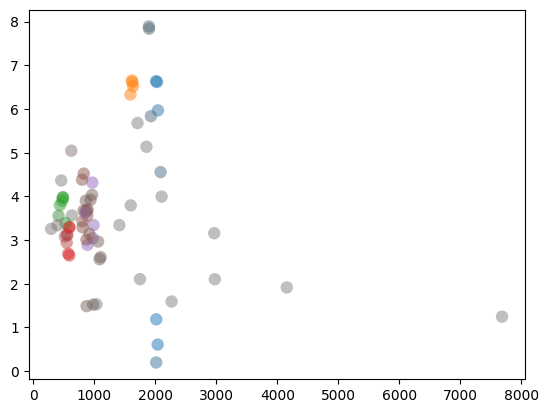

In [90]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(hdb.labels_, hdb.probabilities_)]

plt.scatter(data_for_clustering.values[:, 0], data_for_clustering.values[:, 1], c=cluster_colors, **plot_kwds)
plt.show()


In [ ]:
#combined_df_onlist_events

**Evaluating the HDBSCAN**

In [91]:
# 1. Silhouette score without masking the -1 labels identified as noise by HDBSCAN
labels= combined_df_onlist_events['ClusterHDB_Labels']
# Calculate the silhouette score
score = silhouette_score(data_for_clustering, labels)

print("Silhouette Score: ", score)


Silhouette Score:  0.4548953941957111


In [92]:
# 2. Silhouette score with masking the -1 labels identified as noise by HDBSCAN

# Filter out noise points for silhouette score calculation
mask = cluster_labels != -1
filtered_data = data_for_clustering[mask]
filtered_labels = cluster_labels[mask]

# Calculate the silhouette score
score = silhouette_score(filtered_data, filtered_labels)

print("Silhouette Score: ", score)


Silhouette Score:  0.7036824672293603


In [ ]:
#combined_df_onlist_events.columns

In [93]:
df_alt_duration=combined_df_onlist_events.drop(columns=['event','Avg_Speed', 'Gradient','Lat_start','Long_start', 'Lat_end', 'Long_end'])
df_long_speed=combined_df_onlist_events.drop(columns=['event','Distance_meters', 'Start_Altitude', 'End_Altitude','Lat_start','Long_start', 'Lat_end', 'Long_end'])


In [94]:
#calculate cluster mean for altitude and duration
mean_by_cluster=df_alt_duration.groupby('ClusterHDB_Labels').mean()
mean_by_cluster

<ipython-input-94-c04fcc7c08fb>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_cluster=df_alt_duration.groupby('ClusterHDB_Labels').mean()


,Distance_meters,Start_Altitude,End_Altitude
ClusterHDB_Labels,,,
-1,2193.254118,2045.457023,1841.560498
0,1996.655609,2215.893579,2940.473584
1,1617.812184,1443.872009,2136.598847
2,472.654335,2425.065389,2591.215657
3,555.421662,2149.718445,2338.708130
4,934.332488,2172.619385,2589.713428
5,908.745852,2033.808819,2315.947882


In [95]:
#calculate cluster mean for longitude and speed
mean_by_cluster2=df_long_speed.groupby('ClusterHDB_Labels').mean()
mean_by_cluster2

<ipython-input-95-7574920d0246>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_cluster2=df_long_speed.groupby('ClusterHDB_Labels').mean()


,Gradient,Avg_Speed
ClusterHDB_Labels,,
-1,0.032838,3.118878
0,0.363116,4.733526
1,0.428707,6.530061
2,0.351604,3.766801
3,0.342286,3.257265
4,0.445969,3.443311
5,0.309650,3.317879


<ipython-input-96-d633537253d4>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_colors = cm.get_cmap('tab20', 12)


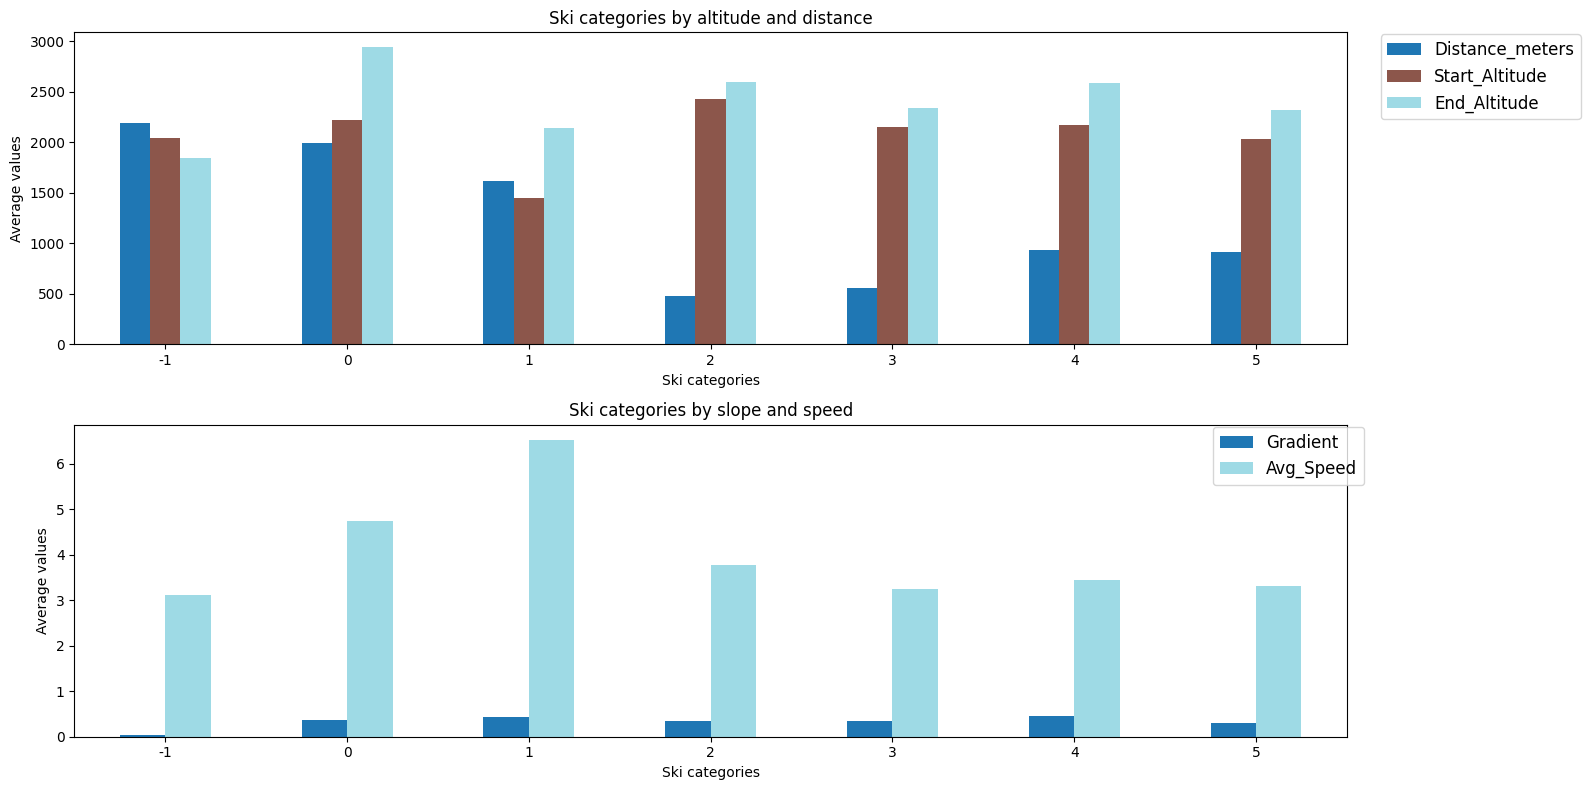

In [96]:
custom_colors = cm.get_cmap('tab20', 12)

# Create a figure with 2 subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))  # Adjust the figsize as needed

# Plot the first set of means on the first subplot (ax1)
mean_by_cluster.plot(kind='bar', ax=ax1, cmap=custom_colors)
ax1.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
ax1.set_xlabel('Ski categories')
ax1.set_xticklabels(mean_by_cluster.index, rotation=0)
ax1.set_ylabel('Average values')
ax1.set_title('Ski categories by altitude and distance')

# Plot the second set of means on the second subplot (ax2)
mean_by_cluster2.plot(kind='bar', ax=ax2, cmap=custom_colors)
ax2.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
ax2.set_xlabel('Ski categories')
ax2.set_xticklabels(mean_by_cluster2.index, rotation=0)
ax2.set_ylabel('Average values')
ax2.set_title('Ski categories by slope and speed')

# The layout
plt.tight_layout()
plt.show()

### **Main Takeaways from clustering**

## Cluster Characteristics:
**Cluster -1**

**Cluster 0**
**Cluster 1**

**Cluster 2**
## Operational Insights:
**Cluster 0**
**Cluster 1**
**Cluster 2**


## Further considerations:


In [97]:
# Create a color map with a distinct color for each cluster label, including noise
cluster_labels = combined_df_onlist_events['ClusterHDB_Labels']
unique_labels = np.unique(cluster_labels)
colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))
color_dict = dict(zip(unique_labels, colors))

# Initialize the map at the mean location of the start points
mean_lat = combined_df_onlist_events['Lat_start'].mean()
mean_lon = combined_df_onlist_events['Long_start'].mean()
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# Add points to the map
for _, row in combined_df_onlist_events.iterrows():
    # Assign a color from the color map
    color = color_dict[row['ClusterHDB_Labels']]

    # Convert RGBA color to HEX
    color = mcolors.rgb2hex(color)

    # Plot start point
    folium.CircleMarker(
        location=(row['Lat_start'], row['Long_start']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {row['ClusterHDB_Labels']}"
    ).add_to(m)

    # Plot end point
    folium.CircleMarker(
        location=(row['Lat_end'], row['Long_end']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {row['ClusterHDB_Labels']}"
    ).add_to(m)

# Display the map
m


**Clustering using DBSCAN**

In [ ]:
# Extract latitude and longitude for clustering
coords = combined_df_onlist_events[['Long_start', 'Lat_start']]

# Apply DBSCAN
db = DBSCAN(eps=0.001, min_samples=2, metric='haversine').fit(coords)

# Assign cluster labels back to the original DataFrame
combined_df_onlist_events['ClusterDB'] = db.labels_

# Filter out noise (-1 labels) if needed ---not needed
#final_df_290_filtered = final_df_290[final_df_290['ClusterDB'] != -1]

# View the clustered DataFrame
combined_df_onlist_events[['event', 'Long_start', 'Lat_start', 'ClusterDB']]

,event,Long_start,Lat_start,ClusterDB
0,0,13.379857,47.358046,-1
1,1,13.382150,47.359557,0
2,2,13.382158,47.359580,0
3,3,13.382135,47.359578,0
4,4,13.382468,47.358960,0
...,...,...,...,...
0,0,8.621232,46.656170,11
1,1,8.634004,46.655953,12
2,2,8.652546,46.661611,4
3,3,8.652339,46.661120,4


In [ ]:
# Summary statistics for clusters
combined_df_onlist_events['ClusterDB'].value_counts()

-1     14
 0     10
 9      8
 2      7
 8      6
 7      5
 1      4
 3      4
 5      4
 12     4
 10     3
 4      2
 6      2
 11     2
Name: ClusterDB, dtype: int64

In [ ]:
def process_dataset(df, gmaps):
    # Ensure 'Timestamp' is in datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Calculate start and end times, and duration
    event_times = df.groupby('event')['Timestamp'].agg(['min', 'max']).reset_index()
    event_times['Duration'] = event_times['max'] - event_times['min']

    # Calculate averages
    event_averages = df.groupby('event')[['Lat', 'Long', 'Speed(m/s)', 'Alt(m)']].mean().reset_index()

    # Identify start and end points
    start_points = df.groupby('event').first().reset_index()
    end_points = df.groupby('event').last().reset_index()

    # Merge all the information
    event_summary = pd.merge(event_times[['event', 'Duration']], event_averages, on='event')
    event_summary = pd.merge(event_summary, start_points[['event', 'Lat', 'Long']], on='event', how='left', suffixes=('', '_start'))
    event_summary = pd.merge(event_summary, end_points[['event', 'Lat', 'Long']], on='event', how='left', suffixes=('', '_end'))

    # Function to get location names
    def lift_names_google(lat, long):
        reverse_geocode_result = gmaps.reverse_geocode((lat, long))
        return reverse_geocode_result[0].get('formatted_address', 'Unknown Location') if reverse_geocode_result else "Unknown Location"

    # Geocode locations
    event_summary['EventName'] = event_summary.apply(lambda x: lift_names_google(x['Lat'], x['Long']), axis=1)
    event_summary['StartLocation'] = event_summary.apply(lambda x: lift_names_google(x['Lat_start'], x['Long_start']), axis=1)
    event_summary['EndLocation'] = event_summary.apply(lambda x: lift_names_google(x['Lat_end'], x['Long_end']), axis=1)

    return event_summary
